In [2]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklego.linear_model import LowessRegression

### Reading in from external source

In [21]:
data = pd.read_csv("../Dataset/Boeri2011/data.csv", na_values=["Undetermined"])
metadata = pd.read_csv("../Dataset/Boeri2011/metadata.csv", index_col=0)
data.head()

,Detector,337 sur,339 sur,342 sur,346 sur,348 sur,350 sur,371 sur,373 sur,409 sur,...,371 2 prel,373 bl,409 2 prel,339 bl,F1,M1,M2,M2 bis,M3,M5
0,ath-miR159a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,35.861534,NaN,NaN,NaN,NaN,35.271656,NaN,NaN,NaN
1,hsa-miR-155,33.203365,31.584763,31.421170,33.572320,31.047272,33.465480,32.770187,34.094116,30.231834,...,30.452183,31.242977,30.483734,32.217457,32.245216,30.821905,32.651768,33.220245,31.659473,31.679094
2,hsa-let-7a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.170340,...,NaN,35.199043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,hsa-let-7b,32.942540,31.247986,27.295233,29.752192,27.563130,30.985458,28.498089,28.940802,26.402890,...,28.862015,27.727740,28.617567,29.550318,29.215017,28.238232,28.948671,28.808065,28.984282,29.992250
4,hsa-let-7c,NaN,34.390118,31.883574,NaN,NaN,32.622950,32.562960,NaN,31.155499,...,31.980860,32.371270,31.983383,32.012190,34.296856,32.522583,NaN,34.781456,NaN,32.557790


In [22]:
metadata.tail()

,Time,Stage,Sex,Age,Histology,Pack-Year,Sample collection,Diagnosis,Death or last FU,Status
Detector,,,,,,,,,,
M1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ctrl
M2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ctrl
M2 bis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ctrl
M3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ctrl
M5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ctrl


In [23]:
table = data.transpose()
mirnas = data.iloc[:,0]
mirnas[:10]

0    ath-miR159a
1    hsa-miR-155
2     hsa-let-7a
3     hsa-let-7b
4     hsa-let-7c
5     hsa-let-7d
6     hsa-let-7e
7     hsa-let-7f
8     hsa-let-7g
9      hsa-miR-1
Name: Detector, dtype: object

In [24]:
cases = []
controls = []
for ind in table.index:
    if ind.endswith("sur"):
        cases.append(ind)
    elif ind[0] in "MF":
        controls.append(ind)
cases = np.array(cases)
controls = np.array(controls)

In [25]:
len(cases), len(controls)

(19, 6)

In [26]:
metadata = pd.concat([metadata.loc[pd.Index(cases)], metadata.loc[pd.Index(controls)]])
metadata.head()

,Time,Stage,Sex,Age,Histology,Pack-Year,Sample collection,Diagnosis,Death or last FU,Status
337 sur,Diagnosis,1a,m,69.0,adeno,100.0,11.09.2001,11.09.2001,14/10/2006,Alive
339 sur,Diagnosis,1b,f,54.0,squamo,30.0,02.10.2002,02.10.2002,28/05/2008,Alive
342 sur,Diagnosis,1b,m,58.0,adeno,40.0,11.01.2002,11.01.2002,27/05/2008,Alive
346 sur,Diagnosis,1a,m,54.0,adeno,30.0,13/02/2002,13/02/2002,28/05/2008,Alive
348 sur,Diagnosis,1a,m,60.0,squamo,40.0,03.04.2002,03.04.2002,01.12.2008,Alive


In [27]:
table = pd.concat([table.loc[pd.Index(cases)], table.loc[pd.Index(controls)]])
table = table.apply(pd.to_numeric)
table.index = list(range(len(table)))
table.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,NaN,33.203365,NaN,32.942540,NaN,33.385296,31.410925,NaN,34.642895,NaN,...,NaN,NaN,34.977580,38.553680,35.626310,33.988240,33.756084,33.682648,NaN,34.842860
1,NaN,31.584763,NaN,31.247986,34.390118,31.573914,30.159042,NaN,31.167364,32.457570,...,NaN,NaN,NaN,34.950283,30.749153,30.657600,30.000550,30.101072,NaN,NaN
2,NaN,31.421170,NaN,27.295233,31.883574,29.407010,29.235598,NaN,28.067333,30.976131,...,NaN,NaN,NaN,34.491684,30.118834,31.026510,30.462840,30.286839,NaN,34.983463
3,NaN,33.572320,NaN,29.752192,NaN,30.862568,28.886066,NaN,31.894330,32.976448,...,NaN,NaN,31.063673,36.091187,30.725380,30.819048,31.035313,30.867853,NaN,NaN
4,NaN,31.047272,NaN,27.563130,NaN,30.548157,28.462091,NaN,33.297090,32.748993,...,NaN,NaN,37.313343,34.976162,31.603668,31.662304,31.418295,31.018944,NaN,NaN


In [28]:
controls = np.array(len(cases)*[0] + len(controls)*[1])

### Drop NAN

In [29]:
np.sort(table.isna().sum())

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  5,  5,  6,  6,  6,  6,  7,
        7,  7,  7,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9, 10,
       10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13,
       13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15,
       16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 22, 22, 22, 22

In [30]:
mask = (table.isna().sum() < 10).to_numpy()
mirnas = mirnas[mask]
table = table.loc[:, mask]

In [31]:
sick = 1 - controls

In [32]:
table = table.fillna(table.mean())

### T-test

In [33]:
X = table

In [34]:
X.columns

Int64Index([  1,   3,   4,   5,   6,   8,   9,  10,  11,  14,
            ...
            350, 360, 371, 372, 376, 377, 378, 379, 380, 381],
           dtype='int64', length=135)

In [35]:
X_healthy, X_cancer = X[controls == 1], X[controls == 0]

In [36]:
results = ttest_ind(X_healthy, X_cancer).pvalue

In [37]:
lowest, pvalues = np.argsort(results)[:5], np.sort(results)[:5]

In [38]:
mirnas.iloc[lowest], pvalues

(9           hsa-miR-1
 177    hsa-miR-361-5p
 153    hsa-miR-323-3p
 25     hsa-miR-127-3p
 33       hsa-miR-133a
 Name: Detector, dtype: object,
 array([0.00610246, 0.01430677, 0.01594273, 0.01636483, 0.01891321]))

### F-test

In [39]:
t3 = table

In [40]:
f, p = f_classif(t3, sick)

In [41]:
np.mean(p)

0.4658382001574995

### ANOVA

In [42]:
t3

,1,3,4,5,6,8,9,10,11,14,...,350,360,371,372,376,377,378,379,380,381
0,33.203365,32.942540,32.883163,33.385296,31.410925,34.642895,32.861380,31.295800,31.468184,28.771715,...,31.814048,32.266100,25.787080,31.164463,34.977580,38.553680,35.626310,33.988240,33.756084,33.682648
1,31.584763,31.247986,34.390118,31.573914,30.159042,31.167364,32.457570,33.123733,31.751812,24.553858,...,31.814048,29.345566,25.612013,27.569298,33.766604,34.950283,30.749153,30.657600,30.000550,30.101072
2,31.421170,27.295233,31.883574,29.407010,29.235598,28.067333,30.976131,33.123733,30.943573,22.803980,...,29.844133,30.228134,24.618128,26.073835,33.766604,34.491684,30.118834,31.026510,30.462840,30.286839
3,33.572320,29.752192,32.883163,30.862568,28.886066,31.894330,32.976448,31.013940,31.933096,23.771850,...,31.407312,31.985397,24.153742,26.768526,31.063673,36.091187,30.725380,30.819048,31.035313,30.867853
4,31.047272,27.563130,32.883163,30.548157,28.462091,33.297090,32.748993,33.123733,29.737385,21.975622,...,31.066130,28.248505,23.620598,25.544441,37.313343,34.976162,31.603668,31.662304,31.418295,31.018944
5,33.465480,30.985458,32.622950,33.220300,29.247787,30.905384,31.982727,33.123733,31.159777,26.147188,...,31.268812,31.329498,26.195158,28.173595,33.766604,34.619114,29.980446,31.592323,31.014832,31.468801
6,32.770187,28.498089,32.562960,31.503323,29.296658,34.330620,31.778627,31.799553,30.021332,22.831999,...,39.614967,28.640276,22.654768,25.368809,31.240160,35.197086,29.451723,30.334568,29.733654,29.685510
7,34.094116,28.940802,32.883163,30.842583,28.897360,30.343403,32.644160,34.917670,30.396084,23.095757,...,32.169018,28.642008,23.953531,26.309116,35.608240,32.756012,31.832073,30.956707,30.049444,30.806578
8,30.231834,26.402890,31.155499,28.607490,27.940006,26.846380,31.344206,33.003784,29.477945,22.540508,...,29.012032,28.786230,22.995474,24.993273,33.000195,31.332754,30.729893,28.499102,29.949202,30.432838
9,29.936075,27.609346,33.668620,27.855080,26.090443,26.389214,32.796726,31.722440,29.029097,22.998652,...,29.340540,29.922781,23.572311,25.651802,33.875774,32.106968,33.119220,32.231860,33.793640,33.253593


In [43]:
X = np.array(sick).reshape(-1, 1)

In [44]:
linreg = LinearRegression()
linreg.fit(X, t3)

LinearRegression()

In [45]:
fitted = linreg.predict(X)
explained_variance_score(t3, fitted)

0.05030757032213405

### Mean-variance-plot

In [46]:
np.mean(table)

1      32.171696
3      28.971119
4      32.883163
5      30.775670
6      28.892467
         ...    
377    33.668522
378    31.556774
379    31.338179
380    31.303672
381    31.379806
Length: 135, dtype: float64

In [47]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [48]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

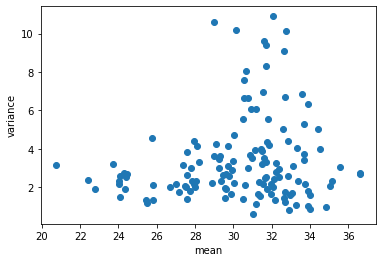

In [49]:
mean_variance_plot(table)

### Log transformation

In [50]:
log_table = table#np.log2(table)

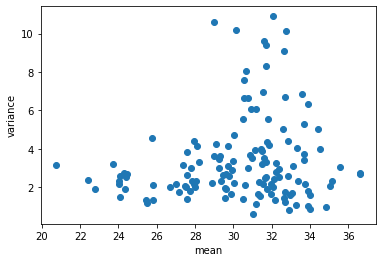

In [51]:
mean_variance_plot(log_table)

### Remove mean

In [52]:
norm_log_table = log_table - np.mean(log_table)
norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

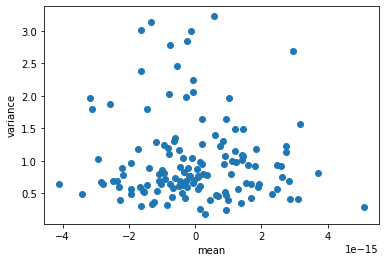

In [53]:
mean_variance_plot(norm_log_table)

### PCA

In [54]:
pca = decomposition.PCA(n_components=10)

In [55]:
pca.fit(norm_log_table)

PCA(n_components=10)

In [56]:
pca.explained_variance_ratio_

array([0.53635913, 0.08348387, 0.0558539 , 0.03737584, 0.0332968 ,
       0.03118454, 0.03028137, 0.02381417, 0.02014543, 0.01874549])

In [57]:
components = pca.transform(norm_log_table)

In [58]:
components.shape

(25, 10)

In [59]:
sum(controls)

6

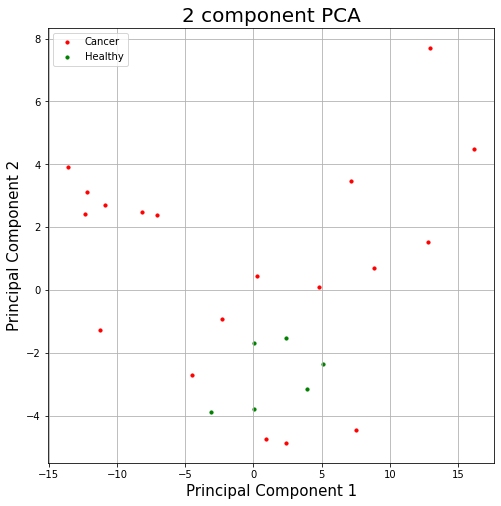

In [60]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [61]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

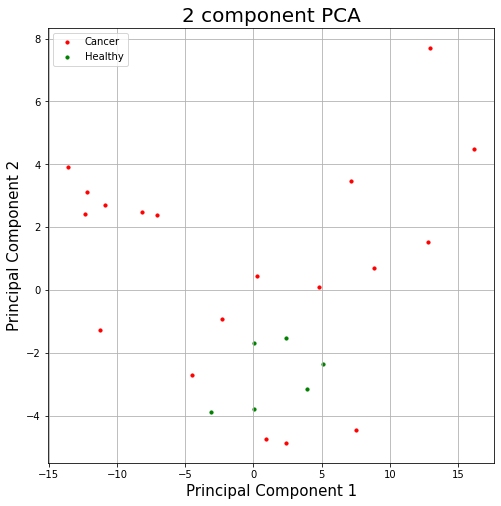

In [62]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Linear regression adjustments

In [72]:
covars = metadata[["Sex", "Age", "Pack-Year"]]

In [73]:
covars["Sex"] = covars["Sex"] == "f"

C:\Users\OLEFRE~1\AppData\Local\Temp/ipykernel_10428/2294964231.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covars["Sex"] = covars["Sex"] == "f"


In [75]:
covars = covars.fillna(covars.mean())

In [76]:
linreg = LinearRegression()
linreg.fit(covars, norm_log_table)

LinearRegression()

In [77]:
adj_norm_log_table = norm_log_table - linreg.predict(covars)

# PCA

In [78]:
pca = decomposition.PCA(n_components=2)

In [79]:
pca.fit(adj_norm_log_table)

PCA(n_components=2)

In [80]:
components = pca.transform(adj_norm_log_table)

In [81]:
components

array([[-1.25798529e+01, -1.83628084e-01],
       [-5.70573191e+00, -1.29532640e+00],
       [ 7.82867355e+00, -3.73012233e+00],
       [-9.59427044e-01, -3.39020844e+00],
       [ 6.10506758e+00,  1.62296348e+00],
       [-7.76084454e+00, -2.62796733e+00],
       [-3.70001019e+00,  2.66239553e+00],
       [ 2.79331539e+00,  2.73533444e+00],
       [ 1.12617804e+01, -3.06779230e+00],
       [ 1.56278559e+01, -8.96428845e-01],
       [ 6.60395551e+00, -2.03277835e+00],
       [-1.46727405e+01, -4.73480621e+00],
       [ 8.69747964e+00,  3.86245468e-01],
       [-1.89232565e+00,  6.49212016e+00],
       [-1.10802564e+01, -2.18593635e+00],
       [-7.33447506e+00,  2.52441083e+00],
       [-8.39566871e+00, -4.31313688e+00],
       [ 1.10036023e+01, -2.32010044e+00],
       [ 1.22637758e+01, -1.37726945e+00],
       [-2.29199670e+00,  1.22579488e+00],
       [ 3.20385595e+00,  4.16552759e+00],
       [ 3.90692317e-02,  1.97505189e+00],
       [-3.95592231e+00,  2.55771569e+00],
       [-1.

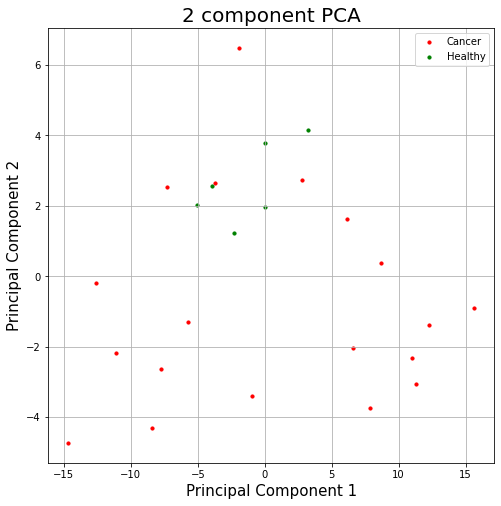

In [82]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [84]:
X_train, X_test, y_train, y_test = train_test_split(adj_norm_log_table, controls, test_size=0.33, random_state=42)

In [85]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

C:\Users\Ole Fredrik\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


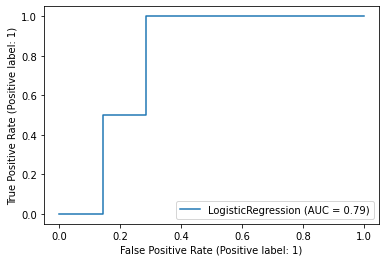

In [86]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [87]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[13:00:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

C:\Users\Ole Fredrik\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


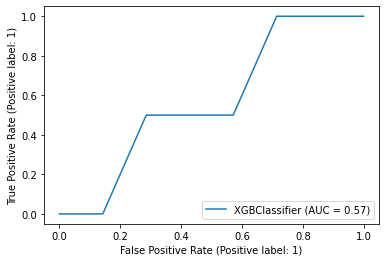

In [88]:
plot_roc_curve(model, X_test, y_test)

### Export data

In [89]:
mirnas[:10]

1      hsa-miR-155
3       hsa-let-7b
4       hsa-let-7c
5       hsa-let-7d
6       hsa-let-7e
8       hsa-let-7g
9        hsa-miR-1
10     hsa-miR-100
11     hsa-miR-101
14    hsa-miR-106a
Name: Detector, dtype: object

In [90]:
from Scripts import converters

In [91]:
sequences = converters.canonical_to_seq(mirnas, True)

In [92]:
sequences.count(None)

4

In [93]:
sequences = np.array(sequences)
mask = sequences != None
sequences = sequences[mask]
adj_norm_log_table = adj_norm_log_table.loc[:, mask]

In [94]:
adj_norm_log_table.columns = sequences
adj_norm_log_table["cancer"] = sick
adj_norm_log_table.head()

,UUAAUGCUAAUCGUGAUAGGGGUU,CGGGGUGAGGUAGUAGGUUGUGUGGUUUCAGGGCAGUGAUGUUGCCCCUCGGAAGAUAACUAUACAACCUACUGCCUUCCCUG,GCAUCCGGGUUGAGGUAGUAGGUUGUAUGGUUUAGAGUUACACCCUGGGAGUUAACUGUACAACCUUCUAGCUUUCCUUGGAGC,CCUAGGAAGAGGUAGUAGGUUGCAUAGUUUUAGGGCAGGGAUUUUGCCCACAAGGAGGUAACUAUACGACCUGCUGCCUUUCUUAGG,CCCGGGCUGAGGUAGGAGGUUGUAUAGUUGAGGAGGACACCCAAGGAGAUCACUAUACGGCCUCCUAGCUUUCCCCAGG,AGGCUGAGGUAGUAGUUUGUACAGUUUGAGGGUCUAUGAUACCACCCGGUACAGGAGAUAACUGUACAGGCCACUGCCUUGCCA,UGGAAUGUAAAGAAGUAUGUAU,AACCCGUAGAUCCGAACUUGUG,UACAGUACUGUGAUAACUGAA,AAAAGUGCUUACAGUGCAGGUAG,...,UGUGCUUGCUCGUCCCGCCCGCA,AAUGGCGCCACUAGGGUUGUG,UACCCAUUGCAUAUCGGAGUUG,UGCGGGGCUAGGGCUAACAGCA,UCCAUUACACUACCCUGCCUCU,UAUUGCACUUGUCCCGGCCUGU,CAAAGUGCUGUUCGUGCAGGUAG,AACCCGUAGAUCCGAUCUUGUG,CACCCGUAGAACCGACCUUGCG,cancer
0,0.721612,1.490660,-0.182381,1.787949,1.122998,2.180461,-0.230479,-1.073664,0.291614,1.749285,...,0.073180,-0.084023,0.851639,0.241405,1.206522,0.642921,1.774732,0.077216,2.457289,1
1,-0.466995,1.221890,0.887933,0.039764,0.464400,0.258920,-0.060873,0.230933,0.675788,0.727021,...,-0.474015,1.516926,0.212303,-0.000724,0.409321,0.770932,0.872899,0.118306,0.543722,1
2,-0.214575,-0.973685,-0.707356,-0.876956,0.180003,-1.862446,-1.077975,0.077972,0.234853,-0.480714,...,0.017270,-0.811243,0.626416,-1.231934,0.527728,0.332393,-0.205930,-0.121687,0.034801,1
3,0.898235,0.670670,-0.083178,-0.159765,0.147016,0.296805,0.084766,-1.086969,0.873769,0.286392,...,-0.597469,-0.114594,0.834737,-0.477486,1.456476,0.226110,0.366760,-1.345379,1.057674,1
4,-0.360275,-1.019308,-0.235372,-0.265013,-0.348700,0.837259,-0.155856,0.118555,-0.478967,-0.997265,...,-0.078812,-1.054290,-0.565982,-0.541096,-0.457936,-0.295008,-0.552588,1.650483,0.124047,1


In [95]:
adj_norm_log_table.to_csv("../TransformedData/Boeri2011_adjusted.csv", index=False)